# Calibration Tutorial

## Step 1: Getting the Data

Note: Step 1 can be bypassed if necessary. Just unzip `tutorials/2_Fort_Peck/data/prepped_input.zip` and proceed to Step 2.

This tutorial is going to focus on calibrating the SWIM for a single unirrigated plot, which is a 150 meter buffer around FluxNet's US-Fpe eddy covariance station. This will be interesting because the flux station has independent observations of both meteorology and the ET flux itself. Let's see if we can improve upon our *a priori* estimates of soil hydraulic parameters and our default parameterization of the snow and Kcb model (function of NDVI).

This notebook bases all it's work on the polygons in `tutorials/2_Fort_Peck/data/gis/flux_fields.shp`.

This notebook is easily modified to get all the flux station's input data; just remove the `select` or like arguments (`field_select`/`target_fields`, etc.) so it doesn't run on only our focus, the station at Fort Peck. This would additionally require downloading the entire bias correction GeoTIFF data set, from the Earth Engine asset folder `projects/ee-dgketchum/assets/swim/gridmet_bias_correction`.

We won't cover the details of compiling data for the modeling run unless it is a different approach than what we did in the first tutorial, `1_Boulder`. Revisit that tutorial's steps 2-4 for further explanation of what we speed through below. Let's get started:

In [29]:
import os
import sys
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import ee

home = os.path.expanduser('~')
root = os.path.join(home, 'PycharmProjects', 'swim-rs')
sys.path.append(root)

from data_extraction.ee.ee_utils import is_authorized
from data_extraction.ee.etf_export import sparse_sample_etf
from data_extraction.ee.ndvi_export import sparse_sample_ndvi
from data_extraction.ee.snodas_export import sample_snodas_swe
from data_extraction.snodas.snodas import create_timeseries_json
from data_extraction.ee.ee_props import get_irrigation, get_ssurgo

from utils.google_bucket import list_and_copy_gcs_bucket

from data_extraction.gridmet.gridmet import get_gridmet_corrections
from data_extraction.gridmet.gridmet import download_gridmet

from prep.field_properties import write_field_properties
from prep.field_timeseries import join_daily_timeseries
from prep.landsat_sensing import sparse_landsat_time_series, join_remote_sensing, detect_cuttings

from prep.field_timeseries import join_daily_timeseries
from prep.prep_plots import prep_fields_json

# Set matplotlib to display inline
%matplotlib inline

command = '/home/dgketchum/google-cloud-sdk/bin/gsutil'
bucket = 'wudr'

data = os.path.join(root, 'tutorials', '2_Fort_Peck', 'data')
shapefile_path = os.path.join(data, 'gis', 'flux_fields.shp')
gdf = gpd.read_file(shapefile_path)
gdf.shape

FEATURE_ID = 'field_1'


In [13]:
gdf.columns

Index(['field_1', 'field_2', 'field_3', 'field_4', 'field_5', 'field_6',
       'field_7', 'field_8', 'field_9', 'field_10', 'field_11', 'field_12',
       'field_13', 'field_14', 'AmeriFlux', 'field_16', 'field_17', 'field_18',
       'field_19', 'field_20', 'LAT', 'LON', 'FID', 'GFID', 'STATION_ID',
       'ELEV', 'geometry'],
      dtype='object')

The shapefile is derived from John Volk's work, which is documented here: https://www.sciencedirect.com/science/article/pii/S0168192323000011

Their paper used a sophisticated method for determining the area on the ground that contibutes to the flux observation. Instead of using their footprints, we're going to use a 150-m buffer around the station for simplicity. We're just going to use one station from the dataset, US-FPe.

In [3]:
gdf.index = gdf[FEATURE_ID]
gdf = gdf.loc[['US-FPe']].copy()
gdf

,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,...,AmeriFlux,field_16,field_17,field_18,field_19,field_20,LAT,LON,FID,geometry
field_1,,,,,,,,,,,,,,,,,,,,,
US-FPe,US-FPe,Grasslands,MT,AmeriFlux,01/2000-06/2008,1.07,48.3077,-105.1019,634.0,Grassland,...,10.17190/AMF/1246053,Tilden Meyers,PI,NOAA/ARL,Tilden.Meyers@noaa.gov,Fort Peck,48.308,-105.102,US-FPe,"POLYGON ((-680433.078 2844690.617, -680440.42 ..."


In [4]:
gdf.geometry.centroid

field_1
US-FPe    POINT (-680583.078 2844690.617)
dtype: geometry

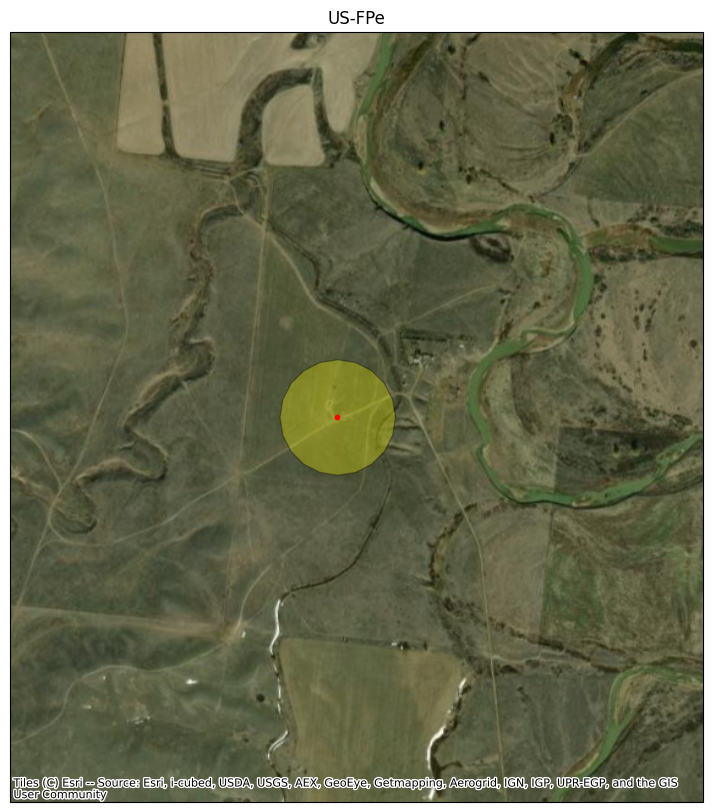

In [5]:
import contextily as ctx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})

gdf.plot(ax=ax,
         edgecolor='black',
         facecolor='yellow',
         alpha=0.3,
         legend=True,
         transform=ccrs.epsg(5071))

gdf.geometry.centroid.plot(ax=ax, markersize=10, color='red', transform=ccrs.epsg(5071))

# Set the extent (x0, x1, y0, y1) to "zoom out"
ax.set_extent([-679633.078, -681433.078, 2843690.6, 2845690.6], crs=ccrs.epsg(5071))
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('US-FPe')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Instead of using the `clustered_sample_etf` like in the first tutorial, we're going to use `sparse_sample_etf` since we only have one station. We would use the same if we selected from more stations, as they are spread out. The`sparse_sample_etf` function accepts a shapefile.

We can use the `select` argument and use a list of our single feature ID to only export that data. 

Note: In this tutorial, you can modify the function calls to export data for all the flux stations easily; just remove the `select` arguments, and it will get all the data needed for the validation tutorial.

### 1. Earth Engine Remote Sensing Extracts

In [11]:
landsat = os.path.join(data, 'landsat')
extracts = os.path.join(landsat, 'extracts')
tables = os.path.join(landsat, 'tables')
if not os.path.isdir(tables):
    os.makedirs(tables, exist_ok=True)

In [13]:
# The extraction
is_authorized()
bucket = 'wudr'

for src in ['ndvi', 'etf']:
    for mask in ['inv_irr', 'irr']:
        
        dst = os.path.join(data, 'landsat', src, mask)
        
        if not os.path.exists(dst):
            os.makedirs(dst, exist_ok=True)

        if src == 'etf':
            print(src, mask)
            sparse_sample_etf(shapefile_path, bucket, debug=False, mask_type=mask, check_dir=None, 
                              start_yr=1987, end_yr=2022, feature_id=FEATURE_ID, select=['US-FPe'])
        if src == 'ndvi':
            print(src, mask)
            sparse_sample_ndvi(shapefile_path, bucket, debug=False, mask_type=mask, check_dir=None, 
                               start_yr=1987, end_yr=2022, feature_id=FEATURE_ID, select=['US-FPe'])


Authorized
ndvi inv_irr
US-FPe 1987
ndvi_US-FPe_inv_irr_1987
US-FPe 1988
ndvi_US-FPe_inv_irr_1988
US-FPe 1989
ndvi_US-FPe_inv_irr_1989
US-FPe 1990
ndvi_US-FPe_inv_irr_1990
US-FPe 1991
ndvi_US-FPe_inv_irr_1991
US-FPe 1992
ndvi_US-FPe_inv_irr_1992
US-FPe 1993
ndvi_US-FPe_inv_irr_1993
US-FPe 1994
ndvi_US-FPe_inv_irr_1994
US-FPe 1995
ndvi_US-FPe_inv_irr_1995
US-FPe 1996
ndvi_US-FPe_inv_irr_1996
US-FPe 1997
ndvi_US-FPe_inv_irr_1997
US-FPe 1998
ndvi_US-FPe_inv_irr_1998
US-FPe 1999
ndvi_US-FPe_inv_irr_1999
US-FPe 2000
ndvi_US-FPe_inv_irr_2000
US-FPe 2001
ndvi_US-FPe_inv_irr_2001
US-FPe 2002
ndvi_US-FPe_inv_irr_2002
US-FPe 2003
ndvi_US-FPe_inv_irr_2003
US-FPe 2004
ndvi_US-FPe_inv_irr_2004
US-FPe 2005
ndvi_US-FPe_inv_irr_2005
US-FPe 2006
ndvi_US-FPe_inv_irr_2006
US-FPe 2007
ndvi_US-FPe_inv_irr_2007
US-FPe 2008
ndvi_US-FPe_inv_irr_2008
US-FPe 2009
ndvi_US-FPe_inv_irr_2009
US-FPe 2010
ndvi_US-FPe_inv_irr_2010
US-FPe 2011
ndvi_US-FPe_inv_irr_2011
US-FPe 2012
ndvi_US-FPe_inv_irr_2012
US-FPe 2013
nd

In [14]:
# Copy to local directory; Note the flux-station specific for-loop

# use the following for a full station network extract:
# stations = gdf[FEATURE_ID].tolist()

# use this for just Fort Peck
stations = ['US-FPe']

for src in ['ndvi', 'etf']:
    for mask in ['inv_irr', 'irr']:
        for station in stations:
            dst = os.path.join(data, 'landsat', 'extracts', src, mask)
            if not os.path.isdir(dst):
                os.makedirs(dst, exist_ok=True)
            glob_ = f'{src}_{station}_{mask}'
            list_and_copy_gcs_bucket(command, bucket, dst, glob=glob_, dry_run=False, overwrite=False)

/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/inv_irr/ndvi_US-FPe_inv_irr_1987.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/inv_irr/ndvi_US-FPe_inv_irr_1988.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/inv_irr/ndvi_US-FPe_inv_irr_1989.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/inv_irr/ndvi_US-FPe_inv_irr_1990.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/inv_irr/ndvi_US-FPe_inv_irr_1991.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/inv_irr/ndvi_US-FPe_inv_irr_1992.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/inv_irr/ndvi_US-FPe_inv_irr_1993.csv exists, skipping

In [2]:
# Write to interpolated time series
  
types_ = ['inv_irr', 'irr']
sensing_params = ['ndvi', 'etf']

for mask_type in types_:

    for sensing_param in sensing_params:
        
        yrs = [x for x in range(1987, 2024)]

        ee_data, src = None, None

        ee_data = os.path.join(extracts, sensing_param, mask_type)
        src = os.path.join(tables, '{}_{}_{}.csv'.format('tutorial', sensing_param, mask_type))
        src_ct = os.path.join(tables, '{}_{}_{}_ct.csv'.format('tutorial', sensing_param, mask_type))

        sparse_landsat_time_series(shapefile_path, ee_data, yrs, src, src_ct, feature_id=FEATURE_ID, select=['US-FPe'])

/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/inv_irr
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/etf/inv_irr
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/ndvi/irr
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/extracts/etf/irr
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
20

In [12]:
remote_sensing_file = os.path.join(landsat, 'remote_sensing.csv')
join_remote_sensing(tables, remote_sensing_file)

etf_inv_irr_ct
ndvi_inv_irr_ct
etf_inv_irr
etf_irr
etf_irr_ct
ndvi_inv_irr
ndvi_irr_ct
ndvi_irr


### 2. Other Earth Engine Extracts

In [22]:
snow_dst = os.path.join(data, 'snodas', 'extracts')
if not os.path.isdir(snow_dst):
    os.makedirs(snow_dst, exist_ok=True)

In [4]:
fields =  'users/dgketchum/fields/flux'
sample_snodas_swe(fields, bucket, debug=False, check_dir=snow_dst, overwrite=False, feature_id=FEATURE_ID)

description = 'calibration_irr'
get_irrigation(fields, description, debug=False, selector=FEATURE_ID)

description = 'calibration_ssurgo'
get_ssurgo(fields, description, debug=False, selector=FEATURE_ID)

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

In [23]:
glob_ = 'swe'
list_and_copy_gcs_bucket(command, bucket, snow_dst, glob=glob_, dry_run=False, overwrite=False)
snow =  os.path.join(data, 'snodas', 'snodas.json')
create_timeseries_json(snow_dst, snow_out, feature_id=FEATURE_ID)

/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snodas/extracts/swe_2004_01.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snodas/extracts/swe_2004_02.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snodas/extracts/swe_2004_03.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snodas/extracts/swe_2004_04.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snodas/extracts/swe_2004_05.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snodas/extracts/swe_2004_06.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snodas/extracts/swe_2004_07.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snodas/extracts/swe_2004_08.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/snoda

NameError: name 'snow_out' is not defined

In [6]:
description = 'calibration_ssurgo'
dst = os.path.join(data, 'properties')
list_and_copy_gcs_bucket(command, bucket, dst, glob=description, dry_run=False, overwrite=False)

Copying gs://wudr/calibration_ssurgo.csv: Copying gs://wudr/calibration_ssurgo.csv...
/ [1 files][ 14.7 KiB/ 14.7 KiB]                                                
Operation completed over 1 objects/14.7 KiB.                                     

Copied gs://wudr/calibration_ssurgo.csv to /home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/properties


In [7]:
description = 'calibration_irr'
dst = os.path.join(data, 'properties')
list_and_copy_gcs_bucket(command, bucket, dst, glob=description, dry_run=False, overwrite=False)

/home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/properties/calibration_irr.csv exists, skipping


In [13]:
irr = os.path.join(data, 'properties', 'calibration_irr.csv')
ssurgo = os.path.join(data, 'properties', 'calibration_ssurgo.csv')
properties_json = os.path.join(data, 'properties', 'calibration_properties.json')

write_field_properties(shp=shapefile_path, irr=irr, ssurgo=ssurgo, js=properties_json, index_col=FEATURE_ID, shp_add=None,
                       targets=['US-FPe'])

We can see the Fort Peck location has never been irrigated, according to IrrMapper.

In [14]:
with open(properties_json, 'r') as f:
    properties_dict = json.load(f)
properties_dict['US-FPe']

{'irr': {'1987': 0.0,
  '1988': 0.0,
  '1989': 0.0,
  '1990': 0.0,
  '1991': 0.0,
  '1992': 0.0,
  '1993': 0.0,
  '1994': 0.0,
  '1995': 0.0,
  '1996': 0.0,
  '1997': 0.0,
  '1998': 0.0,
  '1999': 0.0,
  '2000': 0.0,
  '2001': 0.0,
  '2002': 0.0,
  '2003': 0.0,
  '2004': 0.0,
  '2005': 0.0,
  '2006': 0.0,
  '2007': 0.0,
  '2008': 0.0,
  '2009': 0.0,
  '2010': 0.0,
  '2011': 0.0,
  '2012': 0.0,
  '2013': 0.0,
  '2014': 0.0,
  '2015': 0.0,
  '2016': 0.0,
  '2017': 0.0,
  '2018': 0.0,
  '2019': 0.0,
  '2020': 0.0,
  '2021': 0.0,
  '2022': 0.0,
  '2023': 0.0,
  '2024': 0.0},
 'awc': 0.1775607833906229,
 'ksat': 8.683497246126228,
 'clay': 26.05900683846139,
 'sand': 13.162341057404172,
 'area_sq_m': 69528.82373434979}

While the Fort Peck site isn't irrigated, we will run the NDVI analysis anyway so we don't have to write dummy data required for the model run. 

Note: There is an approach to force the model to run on unirrigated lands that we will see later.

In [15]:
cuttings_json = os.path.join(landsat, 'calibration_cuttings.json')
detect_cuttings(remote_sensing_file, irr, irr_threshold=0.1, out_json=cuttings_json, select=['US-FPe'])

Analyzing Irrigation: 100%|███████████████| 161/161 [00:00<00:00, 146355.21it/s]

wrote /home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/landsat/calibration_cuttings.json


### 3. Meteorology Data

Since we are analyzing scattered stations, we accept we will need a different GridMET time series for each station, so we won't save any time associating each field with indexed GridMET cells (like we did with the cluster of fields). Therefore instead of using `find_gridmet_points` as we did in the previous tutorial, we can use the faster `get_gridmet_corrections`, which outputs the same things: a shapefile with the `GFID`s and a `json` file that has each GFID monthly correction factor. The difference is that the `GFID` is just a sequence of integers. This is all we need to proceed with downloading and process the GridMET data.

This has the added benefit of removing the dependency on a vector representation of the GridMET grid, which requires downloading a raster, vectorizing it, and manipulating that shapefile, which is described in the docstring of `find_gridmet_points`.

If running extractions for the entire flux network, you will need to replace the bias correction GeoTIFF residing in this tutorial's `data` directory with the CONUS rasters from Earth Engine (`projects/ee-dgketchum/assets/swim/gridmet_bias_correction`). See https://developers.google.com/earth-engine/guides/exporting_images for tips on downloading.

Let's run the function to extract correction factors and download the data for Fort Peck:

In [19]:
correction_tifs = os.path.join(data, 'bias_correction_tif')

fields_gridmet = os.path.join(data, 'gis', 'flux_fields_gfid.shp')

gridmet_factors = os.path.join(data, 'gis', 'flux_fields_gfid.json')

met = os.path.join(data, 'met_timeseries')
if not os.path.isdir(met):
    os.mkdir(met)

In [20]:
get_gridmet_corrections(fields=shapefile_path,
                        gridmet_ras=correction_tifs,
                        fields_join=fields_gridmet,
                        factors_js=gridmet_factors,
                        feature_id=FEATURE_ID,
                        field_select=['US-FPe'])

Find field-gridmet joins


Assigning GridMET IDs: 100%|█████████████████| 161/161 [00:00<00:00, 257.63it/s]

Writing 1 of 161 input features


In [21]:
download_gridmet(fields_gridmet, gridmet_factors, met, start='1987-01-01', end='2023-12-31',
                 target_fields=['US-FPe'], overwrite=False, feature_id=FEATURE_ID)

### 4. Model Preparation

Now that we have out data together, the rest of the prep process is the same as in the first tutorial.

In [25]:
joined_timeseries = os.path.join(data, 'input_timeseries')
if not os.path.isdir(joined_timeseries):
    os.mkdir(joined_timeseries)

In [26]:
params = ['etf_inv_irr',
          'ndvi_inv_irr',
          'etf_irr',
          'ndvi_irr']
params += ['{}_ct'.format(p) for p in params]

join_daily_timeseries(fields=fields_gridmet,
                      gridmet_dir=met,
                      landsat_table=remote_sensing_file,
                      snow=snow,
                      dst_dir=joined_timeseries,
                      overwrite=True,
                      start_date='1987-01-01',
                      end_date='2022-12-31', 
                      feature_id=FEATURE_ID,
                      **{'params': params})

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]

1 fields were successfully processed
0 fields were dropped due to missing data


In [30]:
# the model input file
prepped_input = os.path.join(data, 'prepped_input.json')

processed_targets, excluded_targets = prep_fields_json(properties_json, joined_timeseries, prepped_input,
                                                       target_plots=None, irr_data=cuttings_json)

Target sample(s) missing: ['US-Tw2', 'US-Slt', 'US-Fuf', 'US-xNG', 'S2', 'US-Hn3', 'US-xDL', 'US-Wkg', 'WRV_1', 'US-SCs', 'UA2_KN20', 'KV_4', 'WRV_2', 'US-SO4', 'US-A32', 'B_01', 'US-Mj2', 'US-Ced', 'US-SP4', 'US-xNW', 'US-Me2', 'BPHV', 'LYS_SE', 'US-Sne', 'US-Aud', 'US-Hn2', 'US-xJR', 'RIP760', 'US-Me6', 'US-SCg', 'US-Ro4', 'JPL1_JV114', 'SPV_1', 'US-Oho', 'stonevillesoy', 'US-xDC', 'US-Skr', 'US-Blk', 'US-Ro3', 'UA3_JV108', 'BPLV', 'ET_1', 'US-SdH', 'US-Br1', 'US-SCw', 'US-ARM', 'UA1_KN18', 'US-NR1', 'US-Bi1', 'US-Bi2', 'US-Me1', 'US-SRG', 'UMVW', 'US-xSB', 'US-Ro5', 'US-Dk2', 'SV_5', 'BAR012', 'US-Ne1', 'US-Ro1', 'Ellendale', 'UA1_JV187', 'manilacotton', 'US-xYE', 'UA3_KN15', 'SPV_3', 'LYS_NE', 'US-WBW', 'US-Srr', 'US-ADR', 'US-MOz', 'US-SRS', 'US-NC2', 'US-GMF', 'US-Fwf', 'US-FR2', 'US-IB2', 'VR', 'US-CRT', 'ALARC2_Smith6', 'US-Dix', 'US-xDS', 'LYS_NW', 'US-Ne2', 'KV_1', 'US-WCr', 'US-xAE', 'UA1_HartFarm', 'Almond_Med', 'B_11', 'US-Fmf', 'SV_6', 'US-Twt', 'US-xRM', 'US-Ro2', 'US-Mj

100%|████████████████████████████████████████| 161/161 [00:00<00:00, 271.28it/s]


wrote /home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/prepped_input.json


Note: If you're just running the single station, the code will warn you're missing the other 160 stations. It's not a problem.

Hopefully, that went quick. In Step 2, we'll run an uncalibrated model.